# Reliability  for different desings

## Run Analysis

### Import stuff

In [36]:
import numpy as np 
import nibabel as nib
from nilearn import plotting,image
import pandas as pd 
import os 
import glob 
from os.path import join, exists, split
import numpy as np
from scipy.stats import pearsonr
import scipy.ndimage
from statsmodels.stats.multitest import fdrcorrection
import re

In [ ]:
outdir = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/'
homedir = split(os.getcwd())[0]
datadir = '/Users/danieljanini/Documents/Thesis/miniblock/'
presdir = join(homedir, 'Behavior', 'designmats')
sub = '03'
smoothing = "sm_2_vox"
runtype = 'miniblock'

results_glmsingle = dict()
results_glmsingle['typed'] = np.load(join(outdir,f'sub-{sub}',f'{smoothing}_sub-{sub}_{runtype}/TYPED_FITHRF_GLMDENOISE_RR.npy'), allow_pickle=True).item()
betas = results_glmsingle['typed']['betasmd']

### Use the appropriate mask

In [25]:
brain_mask = image.load_img(join(datadir, 'derivatives', f'sub-{sub}', 'anat', 'visual_voxels_mask_sm_2_vox.nii.gz'))
print("Mask shape:", brain_mask.shape)
print("Mask affine:", brain_mask.affine)
mask = brain_mask.get_fdata()
print("Mask unique values:", np.unique(mask))
masked_betas = betas[mask.astype(bool)]
print("Masked beta shape:", masked_betas.shape)  
unmasked_betas = np.zeros(betas.shape)
unmasked_betas[mask.astype(bool)] = masked_betas
print("Masked betas reverted to original size: ", unmasked_betas.shape)

Mask shape: (77, 95, 82)
Mask affine: [[   2.    0.    0.  -76.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -76.]
 [   0.    0.    0.    1.]]
Mask unique values: [0. 1.]
Masked beta shape: (46514, 240)
Masked betas reverted to original size:  (77, 95, 82, 240)


### get design matrix and get condition_order

In [26]:
pattern = presdir + f'/P0{sub}_ConditionRich_Run*_{runtype}.csv'
matches = glob.glob(pattern)
matches.sort()
design = []
for i in range(len(matches)):
    designMat = pd.read_csv(matches[i], header=None)
    print(f"Size of Design Matrix before upsampling: {designMat.shape}")
    num = re.search(r'Run_(\d+)', matches[i])
    # reminder: the runNum of the designmats is not the same as for the functional data as localizer runs were interspersed 
    runNum = int(num.group(1))
    if (runNum >3) & (runNum < 7) & (sub != '01'): 
        runNum += 1 # localizer run after 3rd functional run
    elif (runNum >= 7):
        runNum += 2 # localizer run after 6th functional run (7th overall)
    elif (sub == '01') & (runNum >4) & (runNum < 7):
        runNum +=1
    design.append(designMat)

Size of Design Matrix before upsampling: (388, 40)
Size of Design Matrix before upsampling: (388, 40)
Size of Design Matrix before upsampling: (388, 40)


In [27]:
all_design = np.vstack((design[0], design[1], design[2]))
condition_mask = all_design.sum(axis=1) > 0
condition_vector = np.argmax(all_design[condition_mask], axis=1)
assert(condition_vector.shape == (240,))

In [28]:
n_conditions = 40
max_reps = 6

repindices = np.full((max_reps, n_conditions), np.nan)

# Fill in the indices
for p in range(n_conditions):  
    inds = np.where(condition_vector == p)[0]  
    repindices[:len(inds), p] = inds  


In [29]:
import numpy as np

# Initialize output
X, Y, Z, T = unmasked_betas.shape
n_reps, n_conds = repindices.shape
betas_per_condition = np.full((X, Y, Z, n_reps, n_conds), np.nan)

# Loop through conditions
for cond in range(n_conds):
    trial_indices = repindices[:, cond]
    
    for rep, trial_idx in enumerate(trial_indices):
        if not np.isnan(trial_idx):
            trial_idx = int(trial_idx)  # convert from float to int
            betas_per_condition[:, :, :, rep, cond] = unmasked_betas[:, :, :, trial_idx]


In [30]:
reliability_map = np.full((X, Y, Z), np.nan)
for x in range(X):
    for y in range(Y):
        for z in range(Z):
            # Extract betas for this voxel across repetitions (shape: (n_reps, n_conds))
            voxel_betas = betas_per_condition[x, y, z, :, :]
            
            # Split into even and odd repetitions
            even_betas_mean = np.mean(voxel_betas[::2, :], axis=0) 
            odd_betas_mean = np.mean(voxel_betas[1::2, :], axis=0)

            
            corr, _ = pearsonr(even_betas_mean, odd_betas_mean)
            
            # Take the mean correlation across conditions (or use another aggregation method)
            reliability_map[x, y, z] = corr


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_2289/2996195012.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


/Users/danieljanini/.local/lib/python3.12/site-packages/nilearn/plotting/html_stat_map.py:198: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(stat_map_img, ensure_finite=True)
/opt/anaconda3/envs/my_python_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



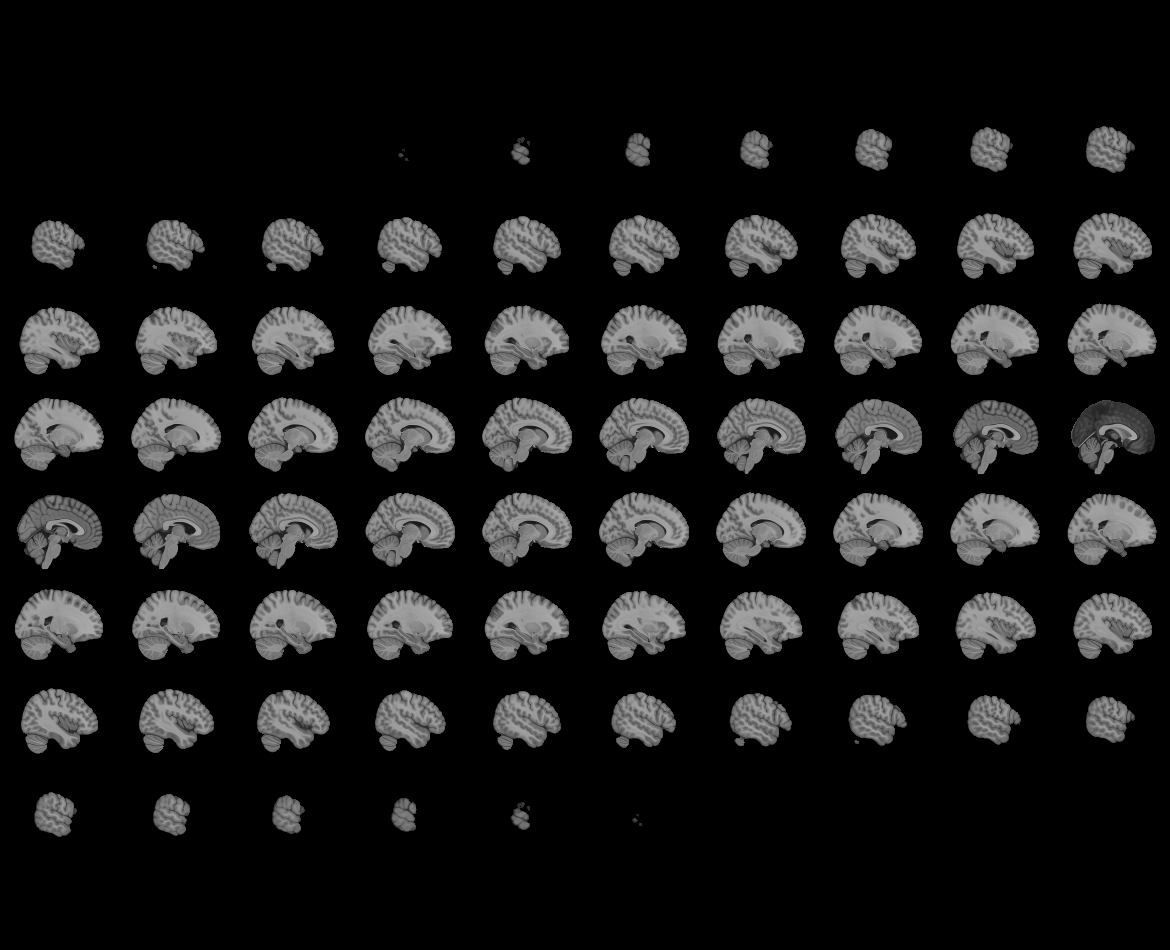
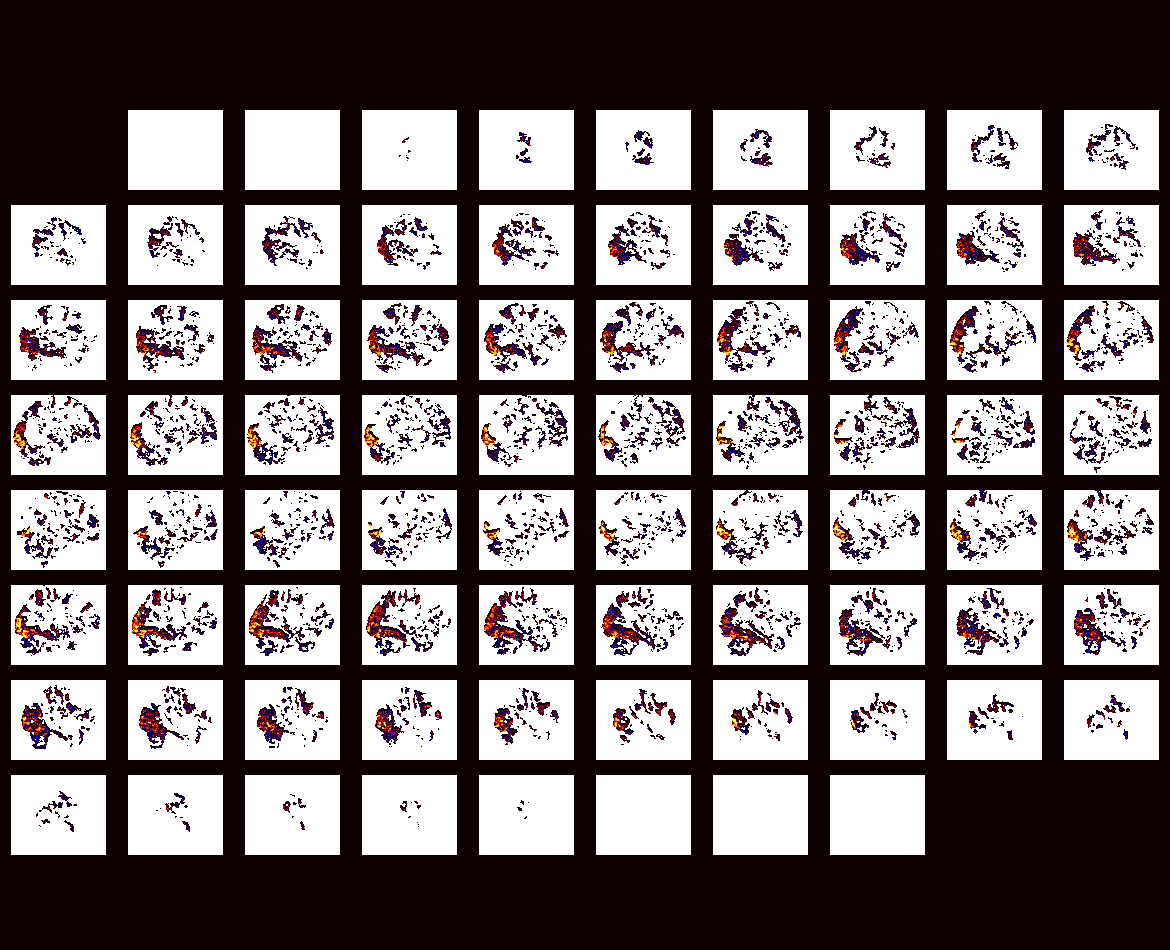

In [16]:
from nilearn.image import new_img_like

# Assuming brain_mask is the original Nifti image you loaded (has correct affine and shape)
reliability_img = new_img_like(brain_mask, reliability_map)

from nilearn.plotting import plot_stat_map

plotting.view_img(reliability_img)


### Full script

In [13]:
from itertools import combinations
elements = [0, 1, 2, 3, 4, 5]

# Get all combinations of 3 elements
group1_list = list(combinations(elements, 3))

# To avoid duplicates (like (group1, group2) and (group2, group1)), only keep half
splits = []
seen = set()

for group1 in group1_list:
    group2 = tuple(sorted(set(elements) - set(group1)))
    # Make sure we haven't already seen this partition
    key = tuple(sorted([group1, group2]))
    if key not in seen:
        seen.add(key)
        splits.append((group1, group2))

In [18]:
import numpy as np
import nibabel as nib
from nilearn import plotting, image
import pandas as pd
import os
import glob
from os.path import join, exists, split
from scipy.stats import pearsonr
import re

outdir = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/'
homedir = split(os.getcwd())[0]
datadir = '/Users/danieljanini/Documents/Thesis/miniblock/'
presdir = join(homedir, 'Behavior', 'designmats')
subs = ["01"]
smooths = ["sm_2_vox", "unsmoothed"]
runtypes = ['miniblock', "er", "sus"]


for sub in subs: 
    counter = 0
    for split in splits: 
        counter += 1
        for runtype in runtypes:
            for smoothing in smooths: 

                print(f'Now working on subject {sub}, condition {runtype}, {smoothing}, and split {counter}')

                results_glmsingle = dict()
                results_glmsingle['typed'] = np.load(join(outdir,f'sub-{sub}',f'{smoothing}_sub-{sub}_{runtype}/TYPED_FITHRF_GLMDENOISE_RR.npy'), allow_pickle=True).item()
                betas = results_glmsingle['typed']['betasmd']

                brain_mask = image.load_img(join(datadir, 'derivatives', f'sub-{sub}', 'func', f'sub-{sub}_task-func_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'))
                mask = brain_mask.get_fdata()

                masked_betas = betas[mask.astype(bool)]
                unmasked_betas = np.zeros(betas.shape)
                unmasked_betas[mask.astype(bool)] = masked_betas

                # Load and process design matrix
                pattern = presdir + f'/P0{sub}_ConditionRich_Run*_{runtype}.csv'
                matches = glob.glob(pattern)
                matches.sort()
                design = []
                for i in range(len(matches)):
                    designMat = pd.read_csv(matches[i], header=None)
                    num = re.search(r'Run_(\d+)', matches[i])
                    runNum = int(num.group(1))
                    # Adjust runNum for interspersed localizer runs
                    if (runNum > 3) & (runNum < 7) & (sub != '01'): 
                        runNum += 1
                    elif (runNum >= 7):
                        runNum += 2
                    elif (sub == '01') & (runNum > 4) & (runNum < 7):
                        runNum += 1
                    design.append(designMat)

                all_design = np.vstack((design[0], design[1], design[2]))
                condition_mask = all_design.sum(axis=1) > 0
                condition_vector = np.argmax(all_design[condition_mask], axis=1)
                n_conditions = 40
                max_reps = 6

                repindices = np.full((max_reps, n_conditions), np.nan)
                for p in range(n_conditions):  
                    inds = np.where(condition_vector == p)[0]  
                    repindices[:len(inds), p] = inds  

                # Preallocate betas_per_condition array
                X, Y, Z, T = unmasked_betas.shape
                n_reps, n_conds = repindices.shape
                betas_per_condition = np.full((X, Y, Z, n_reps, n_conds), np.nan)

                # Populate betas_per_condition array
                for cond in range(n_conds):
                    trial_indices = repindices[:, cond]
                    for rep, trial_idx in enumerate(trial_indices):
                        if not np.isnan(trial_idx):
                            trial_idx = int(trial_idx)
                            betas_per_condition[:, :, :, rep, cond] = unmasked_betas[:, :, :, trial_idx]

                # Compute reliability map
                reliability_map = np.full((X, Y, Z), np.nan)
                for x in range(X):
                    for y in range(Y):
                        for z in range(Z):
                            voxel_betas = betas_per_condition[x, y, z, :, :]
                            even_betas_mean = np.mean(voxel_betas[list(split[0])], axis=0) 
                            odd_betas_mean = np.mean(voxel_betas[list(split[1])], axis=0)
                            corr, _ = pearsonr(even_betas_mean, odd_betas_mean)
                            reliability_map[x, y, z] = corr

                # Save reliability map as NIfTI file
                reliability_img = nib.Nifti1Image(reliability_map, brain_mask.affine)
                reliability_filename = join(outdir, 'reliability', f'sub-{sub}', f'{smoothing}_sub-{sub}_{runtype}_reliability_map_split_{counter}.nii.gz')
                sub_outdir = join(outdir, 'reliability', f'sub-{sub}')
                os.makedirs(sub_outdir, exist_ok=True)
                nib.save(reliability_img, reliability_filename)

                # Store reliability for future analysis
                masked_reliability_values = reliability_map[mask.astype(bool)]
                reliability = np.nanmedian(masked_reliability_values)



Now working on subject 01, condition miniblock, sm_2_vox, and split 1


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 1


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 1


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 1


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 1


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 1


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 2


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 2


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 2


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 2


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 2


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 2


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 3


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 3


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 3


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 3


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 3


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 3


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 4


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 4


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 4


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 4


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 4


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 4


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 5


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 5


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 5


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 5


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 5


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 5


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 6


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 6


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 6


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 6


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 6


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 6


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 7


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 7


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 7


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 7


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 7


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 7


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 8


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 8


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 8


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 8


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 8


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 8


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 9


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 9


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 9


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 9


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 9


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 9


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, sm_2_vox, and split 10


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition miniblock, unsmoothed, and split 10


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, sm_2_vox, and split 10


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition er, unsmoothed, and split 10


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, sm_2_vox, and split 10


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


Now working on subject 01, condition sus, unsmoothed, and split 10


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4068239995.py:90: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(even_betas_mean, odd_betas_mean)


## For existing reliability maps

### If reliability maps were created above, they can be loaded into a dataframe here

In [ ]:
import numpy as np
import nibabel as nib
from nilearn import image
import pandas as pd
import os
from os.path import join, split

outdir = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/reliability/'
homedir = split(os.getcwd())[0]
datadir = '/Users/danieljanini/Documents/Thesis/miniblock/'
presdir = join(homedir, 'Behavior', 'designmats')

subs = ["01", "02", "03", "04", "05", "06", "07", "08", "10", "11", "12", "13", "14", "15", "17", "18", "19"] # excluded participants 9 and 16
smooths = ["unsmoothed", "sm_2_vox"]
runtypes = ['miniblock', "er", "sus"]

results = []

for sub in subs:
    for runtype in runtypes:
        for smoothing in smooths:
            # Load mask
            #brain_mask_path = join(datadir, 'derivatives', f'sub-{sub}', 'anat', f'visual_voxels_mask_{smoothing}.nii.gz')
            brain_mask_path = "/Users/danieljanini/Documents/Thesis/Code/occipital_mask.nii.gz"
            brain_mask = image.load_img(brain_mask_path)
            mask = brain_mask.get_fdata()

            # Construct reliability map path
            reliability_filename = join(outdir, f'sub-{sub}', f'{smoothing}_sub-{sub}_{runtype}_reliability_map.nii.gz')

            if os.path.exists(reliability_filename):
                reliability_img = nib.load(reliability_filename)
                reliability_data = reliability_img.get_fdata()


                masked_reliability_values = reliability_data[mask.astype(bool)]
                median_reliability = np.nanmedian(masked_reliability_values)
                mean_reliability = np.nanmean(masked_reliability_values)
                max_rel = masked_reliability_values[np.nanargmax(masked_reliability_values)]

                results.append({
                    "subject": sub,
                    "runtype": runtype,
                    "smoothing": smoothing,
                    "median_reliability": median_reliability, 
                    "maximum": max_rel, 
                    "mean_reliability": mean_reliability
                })
            else:
                print(f"Missing file: {reliability_filename}")

df = pd.DataFrame(results)



In [19]:
df.head(10)

,subject,runtype,smoothing,median_reliability,maximum,mean_reliability
0,01,miniblock,unsmoothed,0.188185,0.923360,0.212827
1,01,miniblock,sm_2_vox,0.385459,0.940222,0.375201
2,01,er,unsmoothed,0.003654,0.653001,0.007295
3,01,er,sm_2_vox,0.088553,0.797591,0.095352
4,01,sus,unsmoothed,0.121204,0.888444,0.142605
5,01,sus,sm_2_vox,0.272784,0.907304,0.286310
6,02,miniblock,unsmoothed,0.135146,0.875403,0.155946
7,02,miniblock,sm_2_vox,0.293434,0.924765,0.317259
8,02,er,unsmoothed,0.061006,0.746987,0.067883
9,02,er,sm_2_vox,0.135919,0.812787,0.157024


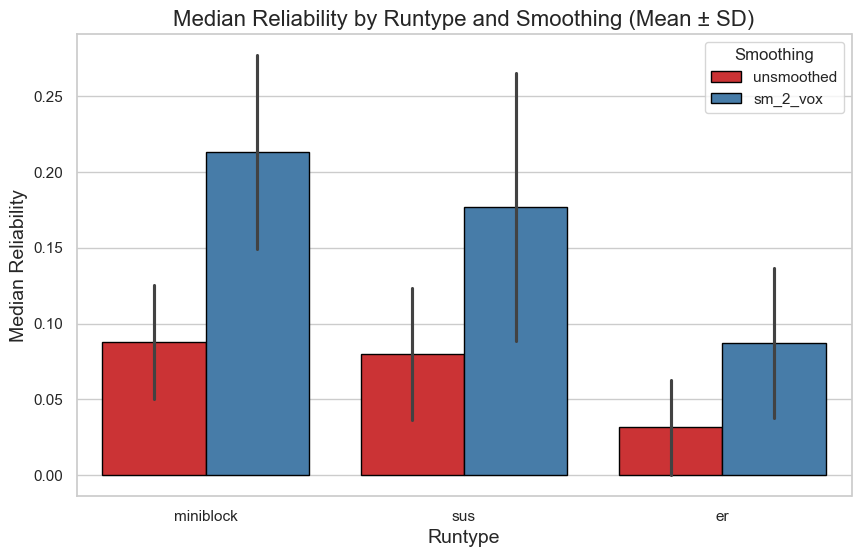

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Set desired order for the x-axis
runtype_order = ['miniblock', 'sus', 'er']
df['runtype'] = pd.Categorical(df['runtype'], categories=runtype_order, ordered=True)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, 
            x='runtype', 
            y='median_reliability', 
            hue='smoothing', 
            errorbar='sd', 
            palette='Set1', 
            edgecolor='black')

# Add labels and title
plt.title('Median Reliability by Runtype and Smoothing (Mean ± SD)', fontsize=16)
plt.xlabel('Runtype', fontsize=14)
plt.ylabel('Median Reliability', fontsize=14)
plt.legend(title='Smoothing', fontsize=11, title_fontsize=12)

plt.show()


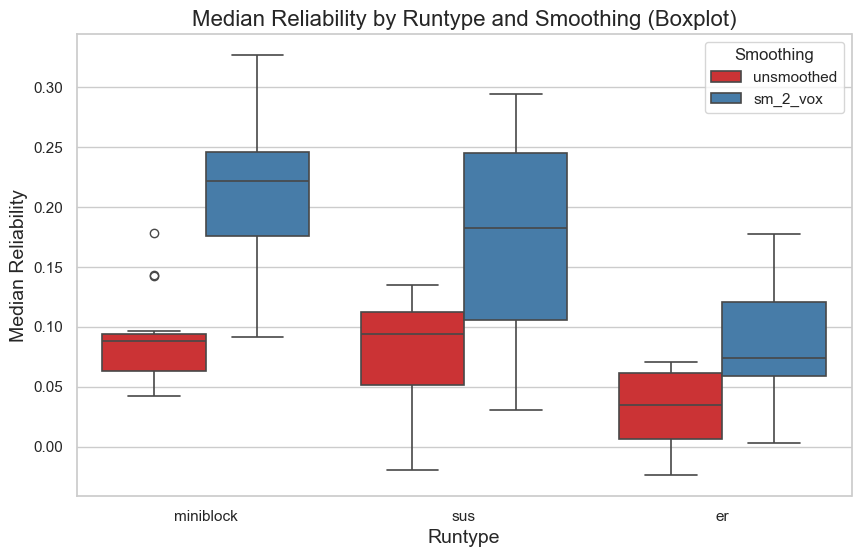

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set desired order for x-axis
runtype_order = ['miniblock', 'sus', 'er']
df['runtype'] = pd.Categorical(df['runtype'], categories=runtype_order, ordered=True)

# Set plot style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, 
            x='runtype', 
            y='median_reliability', 
            hue='smoothing', 
            palette='Set1', 
            linewidth=1.2)

# Add labels and title
plt.title('Median Reliability by Runtype and Smoothing (Boxplot)', fontsize=16)
plt.xlabel('Runtype', fontsize=14)
plt.ylabel('Median Reliability', fontsize=14)
plt.legend(title='Smoothing', fontsize=11, title_fontsize=12)

plt.show()


In [23]:
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

# Make sure subject is a string (important for grouping)
df['subject'] = df['subject'].astype(str)

df_unsmoothed = df[df["smoothing"] == "unsmoothed"]
df_smoothed = df[df["smoothing"] == "sm_2_vox"]

# Run repeated measures ANOVA
anova_unsmoothed = AnovaRM(
    data=df_unsmoothed,
    depvar='mean_reliability',     # dependent variable
    subject='subject',               # repeated-measures subject ID
    within=['runtype']  # within-subject factors
).fit()

# Run repeated measures ANOVA
anova_smoothed = AnovaRM(
    data=df_smoothed,
    depvar='mean_reliability',     # dependent variable
    subject='subject',               # repeated-measures subject ID
    within=['runtype']  # within-subject factors
).fit()

print(anova_smoothed)
print(anova_unsmoothed)

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype 33.9200 2.0000 32.0000 0.0000

                Anova
        F Value Num DF  Den DF Pr > F
-------------------------------------
runtype 23.0690 2.0000 32.0000 0.0000



In [24]:
from scipy.stats import ttest_rel
from itertools import combinations
import statsmodels.stats.multitest as smm

def pairwise_runtype_tests(data, smoothing_level):
    df_filtered = data[data["smoothing"] == smoothing_level]
    
    # Get unique runtypes
    runtypes = df_filtered['runtype'].unique()
    
    # Pivot to wide format: subjects as rows, runtypes as columns
    df_pivot = df_filtered.pivot(index='subject', columns='runtype', values='mean_reliability')

    results = []
    pairs = list(combinations(runtypes, 2))
    for a, b in pairs:
        t_stat, p_val = ttest_rel(df_pivot[a], df_pivot[b])
        results.append((a, b, t_stat, p_val))

    # Correct p-values for multiple comparisons
    p_vals = [r[3] for r in results]
    corrected = smm.multipletests(p_vals, method='bonferroni')
    
    # Combine results
    final_results = []
    for i, (a, b, t_stat, p_val) in enumerate(results):
        final_results.append({
            'comparison': f"{a} vs {b}",
            't_stat': t_stat,
            'raw_p': p_val,
            'corrected_p': corrected[1][i],
            'significant': corrected[0][i]
        })

    return pd.DataFrame(final_results)

# Run for both smoothing levels
results_unsmoothed = pairwise_runtype_tests(df, 'unsmoothed')
results_smoothed = pairwise_runtype_tests(df, 'sm_2_vox')

print("Pairwise comparisons (unsmoothed):")
print(results_unsmoothed)

print("\nPairwise comparisons (sm_2_vox):")
print(results_smoothed)


Pairwise comparisons (unsmoothed):
         comparison    t_stat     raw_p  corrected_p  significant
0   miniblock vs er  5.301210  0.000072     0.000215         True
1  miniblock vs sus  1.579078  0.133882     0.401647        False
2         er vs sus -5.286784  0.000074     0.000221         True

Pairwise comparisons (sm_2_vox):
         comparison    t_stat         raw_p  corrected_p  significant
0   miniblock vs er  8.007599  5.477548e-07     0.000002         True
1  miniblock vs sus  2.349554  3.196390e-02     0.095892        False
2         er vs sus -5.365886  6.306202e-05     0.000189         True


In [25]:
# For each subject and smoothing level, find the runtype with the highest median_reliability
top_runtype_counts = (
    df.loc[df.groupby(['subject', 'smoothing'])['median_reliability'].idxmax()]
    .groupby(['smoothing', 'runtype'])
    .size()
    .reset_index(name='count')
)

print(top_runtype_counts)


    smoothing    runtype  count
0    sm_2_vox  miniblock     12
1    sm_2_vox        sus      5
2  unsmoothed  miniblock     12
3  unsmoothed        sus      5


### Plotting Spaghetti-Plots

/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/4064826124.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsmoothed['runtype'] = pd.Categorical(df_unsmoothed['runtype'], categories=x_order, ordered=True)


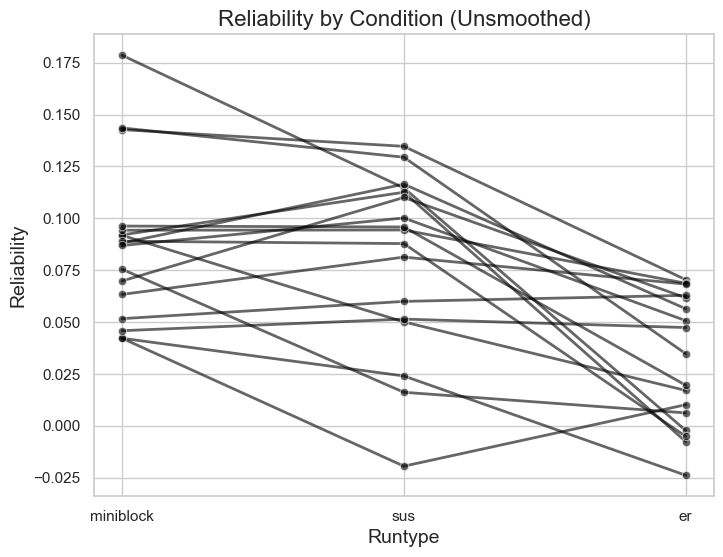

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for unsmoothed condition
df_unsmoothed = df[df['smoothing'] == 'unsmoothed']

# Set plot style
sns.set(style="whitegrid")

# Define and set the desired order for the x-axis labels
x_order = ['miniblock', 'sus', 'er']
df_unsmoothed['runtype'] = pd.Categorical(df_unsmoothed['runtype'], categories=x_order, ordered=True)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot a black line for each subject
for subj, group in df_unsmoothed.groupby('subject'):
    sns.lineplot(data=group, x='runtype', y='median_reliability',
                 marker='o', color='black', linewidth=2, alpha=0.6)

# Add labels and title
plt.title('Reliability by Condition (Unsmoothed)', fontsize=16)
plt.xlabel('Runtype', fontsize=14)
plt.ylabel('Reliability', fontsize=14)

# Remove legend since all lines look the same
plt.legend([], [], frameon=False)

# Show plot
plt.show()


/var/folders/vk/g_509vsj15b_glzh0tx8rln40000gn/T/ipykernel_44487/3024624238.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_smoothed['runtype'] = pd.Categorical(df_smoothed['runtype'], categories=x_order, ordered=True)


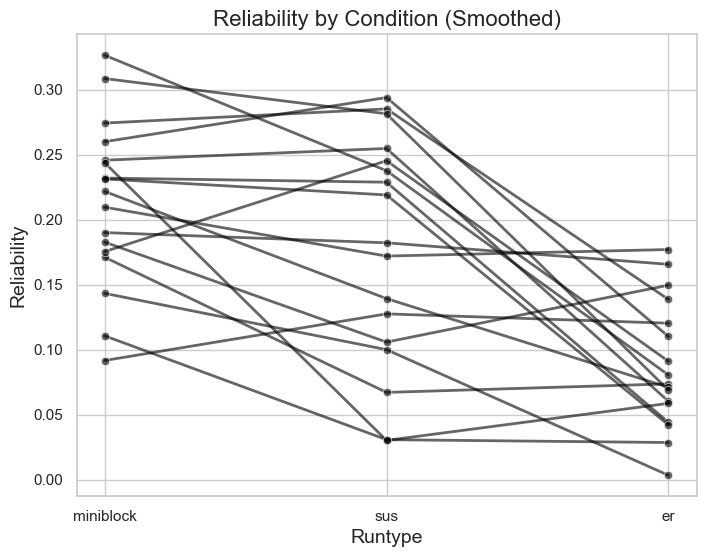

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for unsmoothed condition
df_smoothed = df[df['smoothing'] == 'sm_2_vox']

# Set plot style
sns.set(style="whitegrid")

# Define and set the desired order for the x-axis labels
x_order = ['miniblock', 'sus', 'er']
df_smoothed['runtype'] = pd.Categorical(df_smoothed['runtype'], categories=x_order, ordered=True)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot a black line for each subject
for subj, group in df_smoothed.groupby('subject'):
    sns.lineplot(data=group, x='runtype', y='median_reliability',
                 marker='o', color='black', linewidth=2, alpha=0.6)

# Add labels and title
plt.title('Reliability by Condition (Smoothed)', fontsize=16)
plt.xlabel('Runtype', fontsize=14)
plt.ylabel('Reliability', fontsize=14)

# Remove legend since all lines look the same
plt.legend([], [], frameon=False)

# Show plot
plt.show()


In [2]:
smooths = ["sm_2_vox", "unsmoothed"]
runtypes = ['miniblock', "er", "sus"]
outdir = '/Users/danieljanini/Documents/Thesis/miniblock/Outputs/reliability'

thresholds = np.arange(0, 1, 0.01)
threshold_counts = []

for sub in subs:
    for runtype in runtypes:
        for smoothing in smooths:
            # Construct file path
            reliability_filename = os.path.join(outdir, f'sub-{sub}', f'{smoothing}_sub-{sub}_{runtype}_reliability_map.nii.gz')
            brain_mask_path = join(datadir, 'derivatives', f'sub-{sub}', 'anat', f'visual_voxels_mask_{smoothing}.nii.gz')
            #brain_mask_path = "/Users/danieljanini/Documents/MATLAB/Anatomy/JuBrain_ROIs/occipital_mask.nii.gz"
            brain_mask = image.load_img(brain_mask_path)
            mask = brain_mask.get_fdata()
            
            # Load the reliability map
            if os.path.exists(reliability_filename):
                reliability_img = nib.load(reliability_filename)
                reliability_data = reliability_img.get_fdata()

                masked_reliability_values = reliability_data[mask.astype(bool)]
                
                # Calculate voxel counts above each threshold
                counts = [(masked_reliability_values > t).sum() for t in thresholds]
                threshold_counts.append({
                    "subject": sub,
                    "runtype": runtype,
                    "smoothing": smoothing,
                    "counts": counts
                })


## Threshold Plots

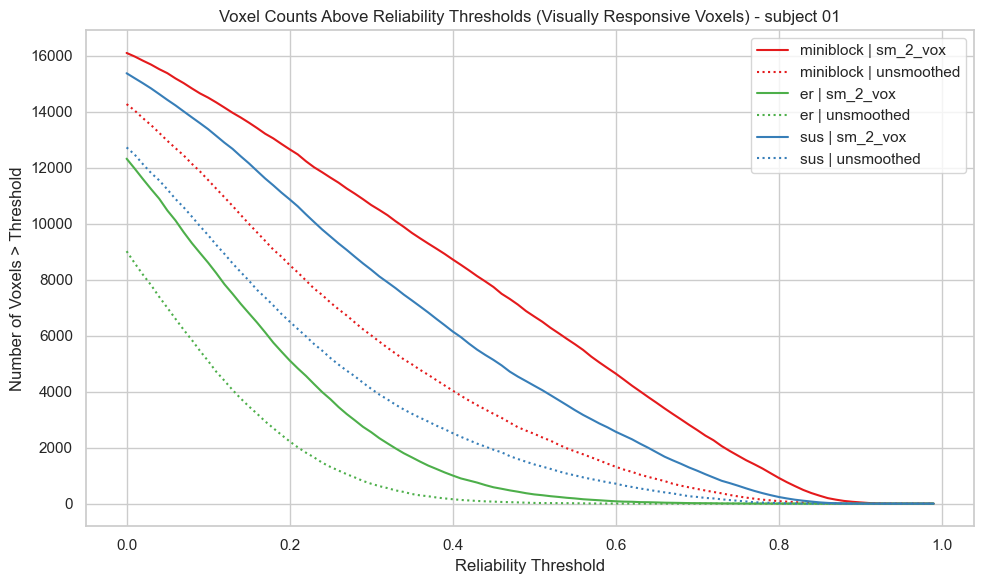

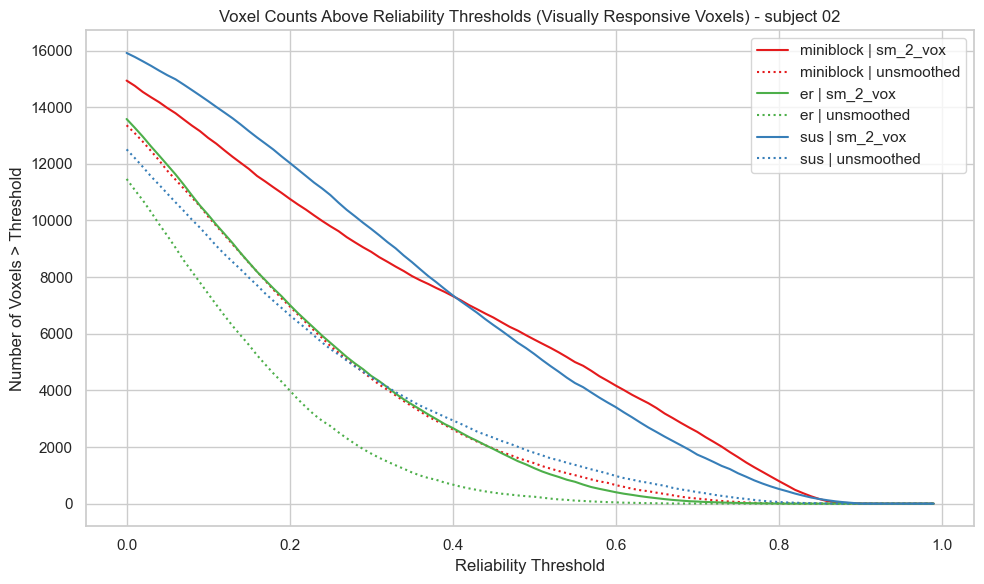

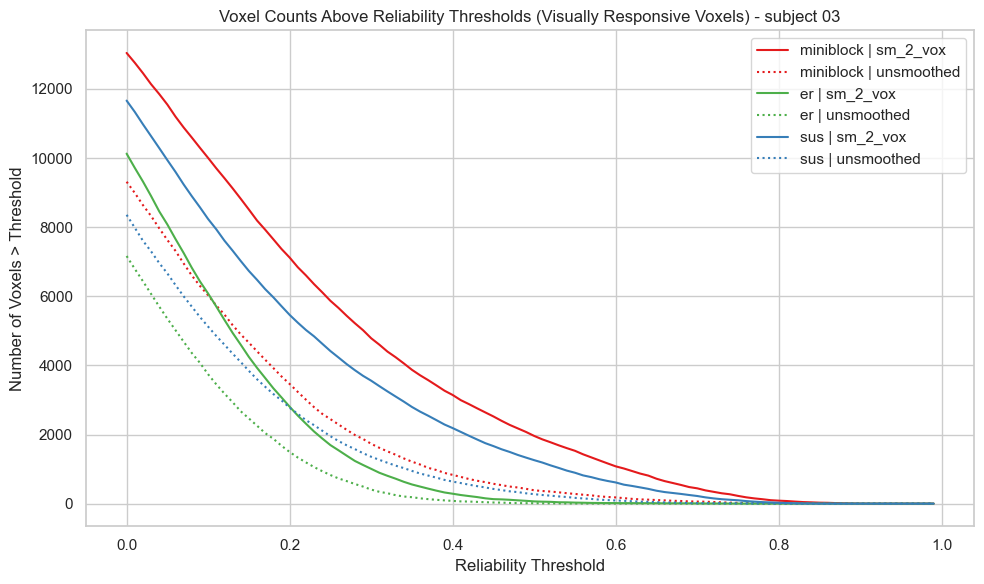

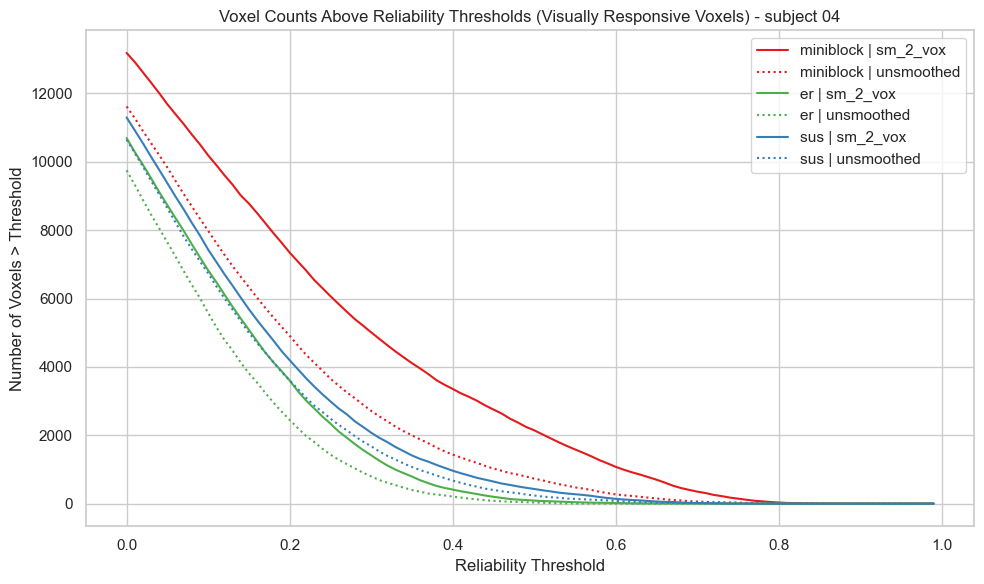

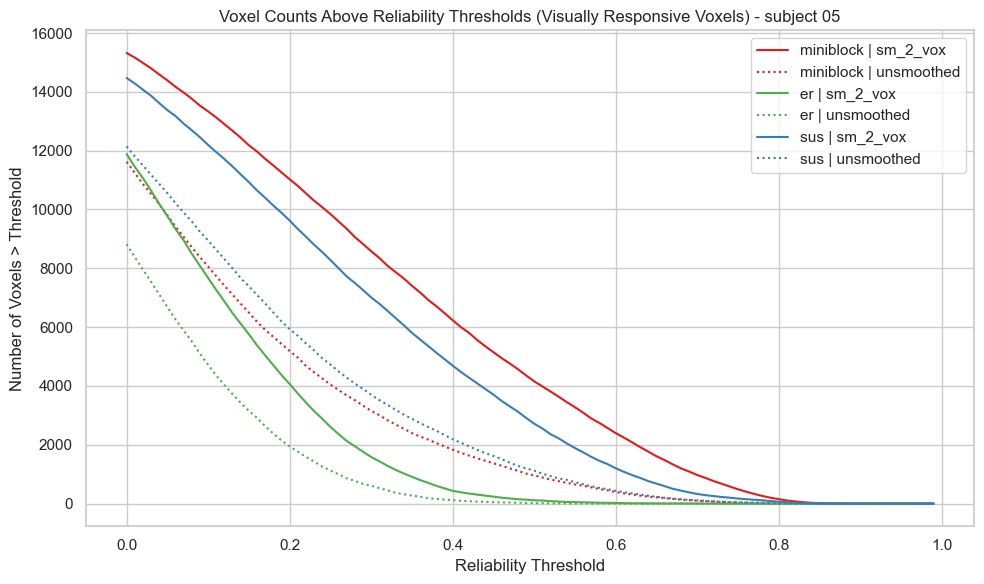

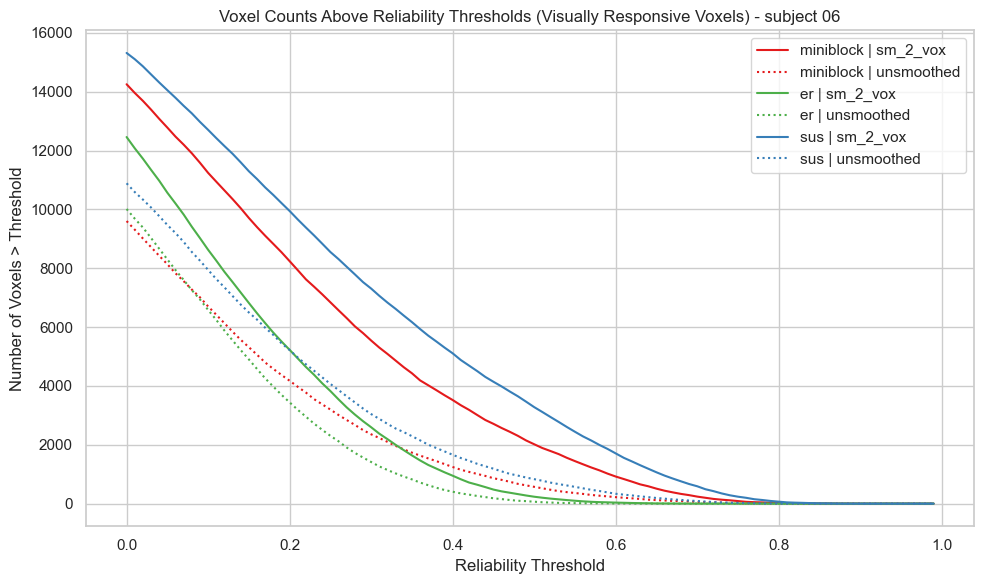

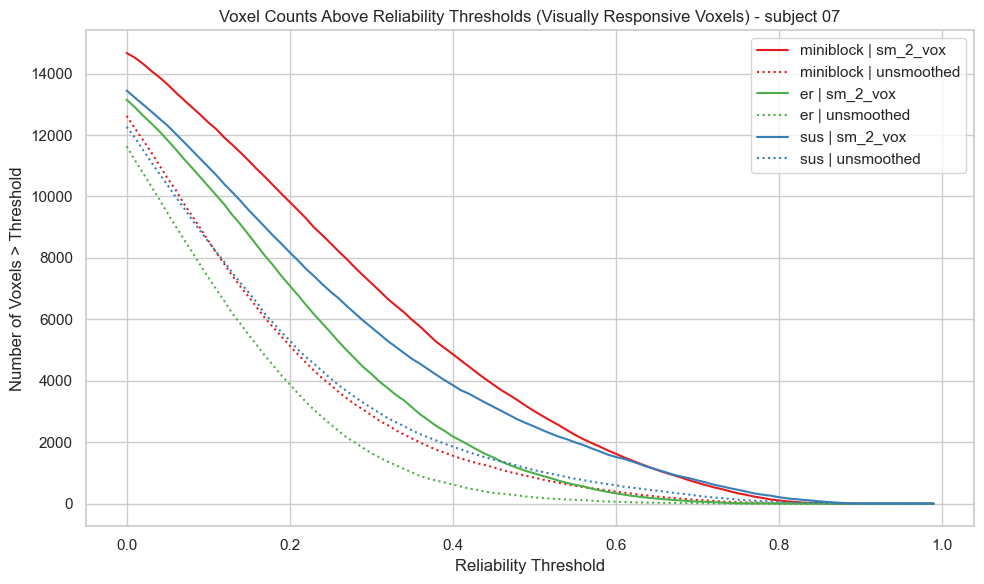

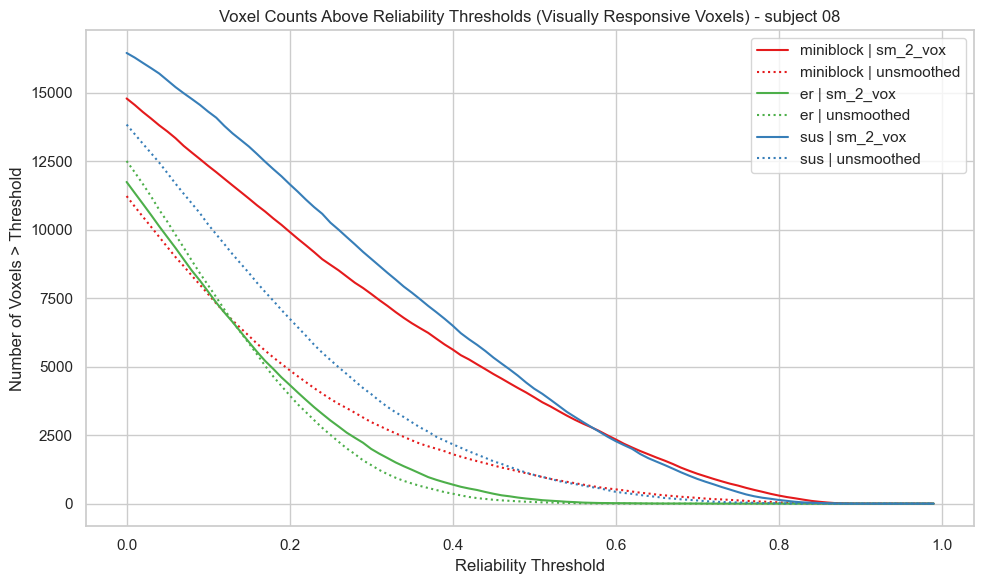

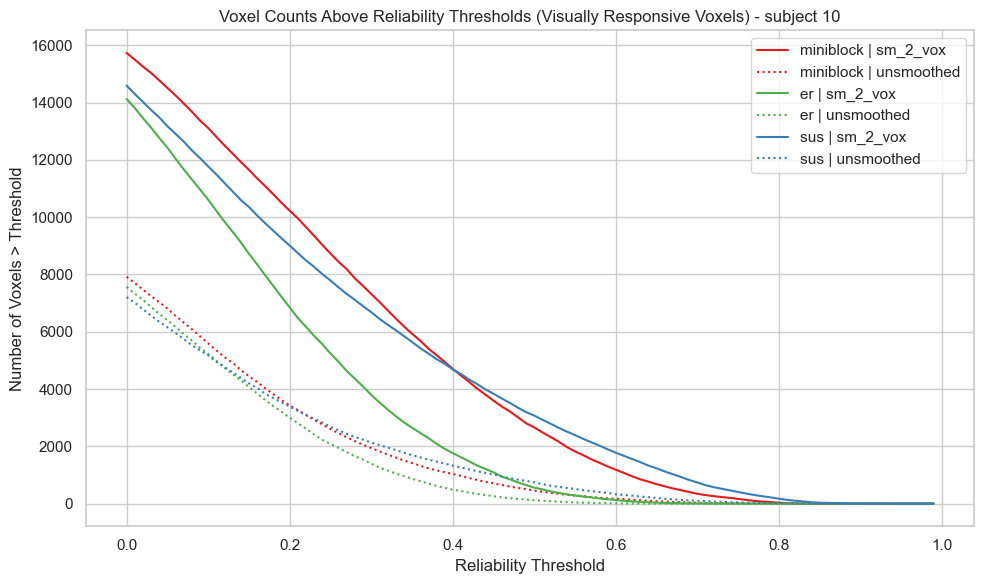

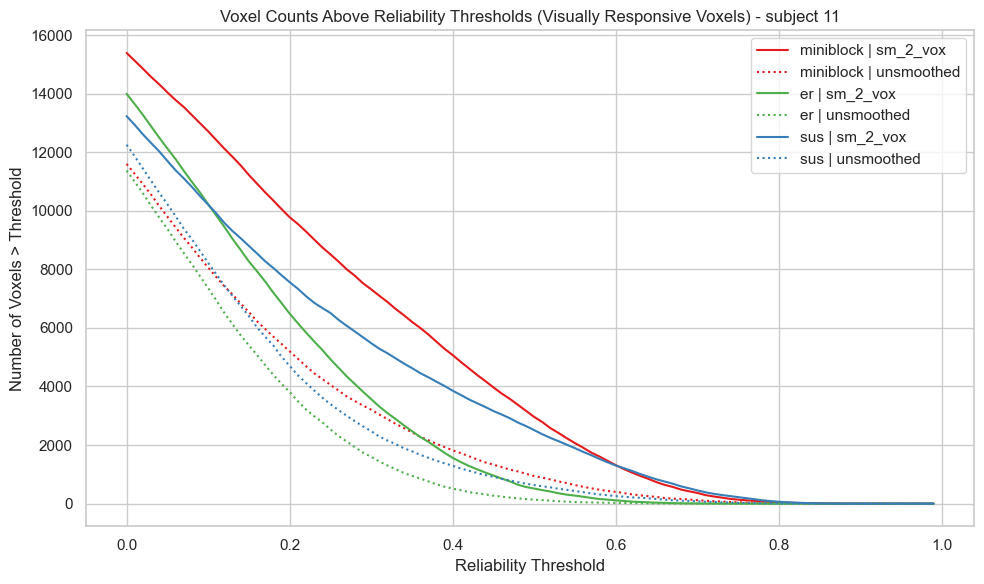

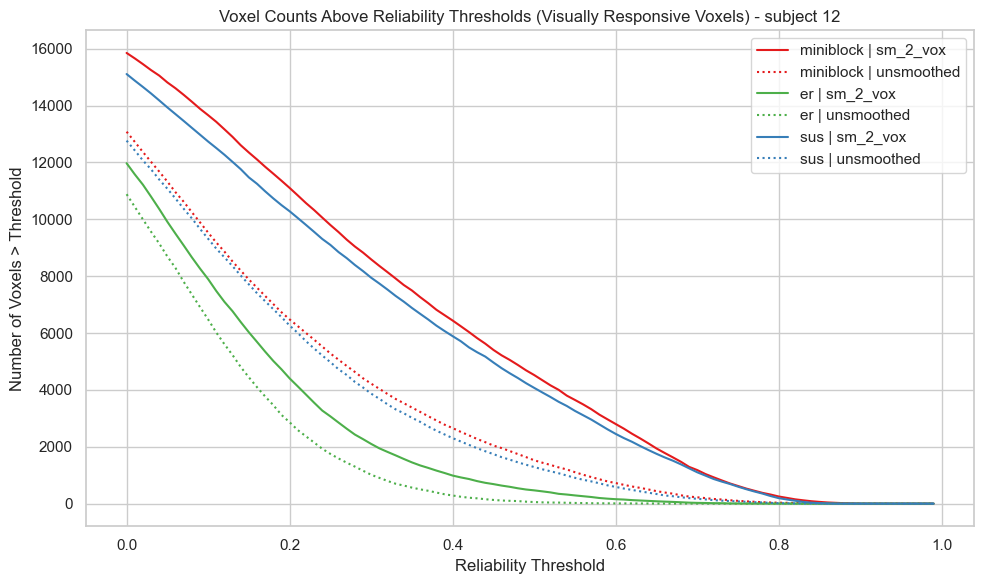

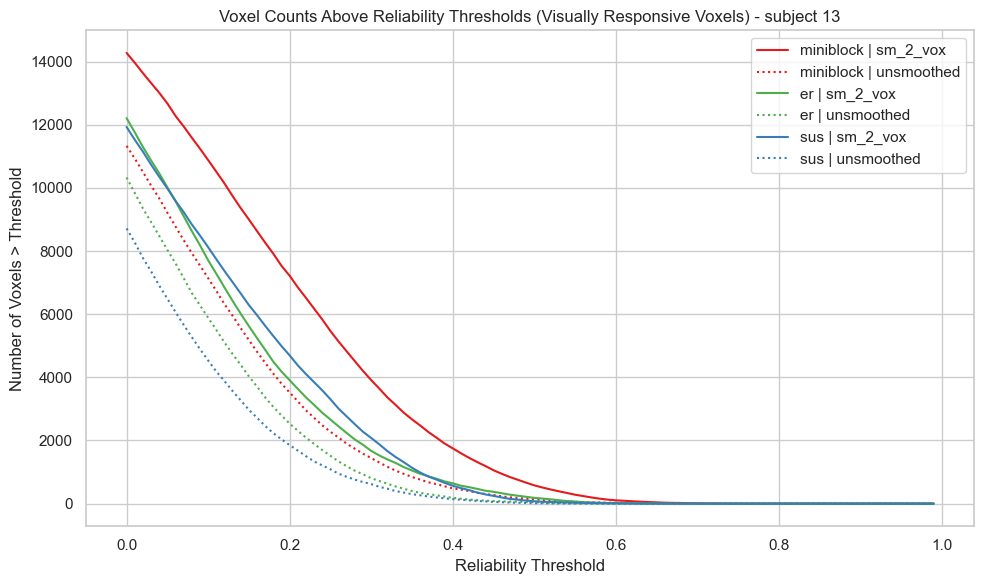

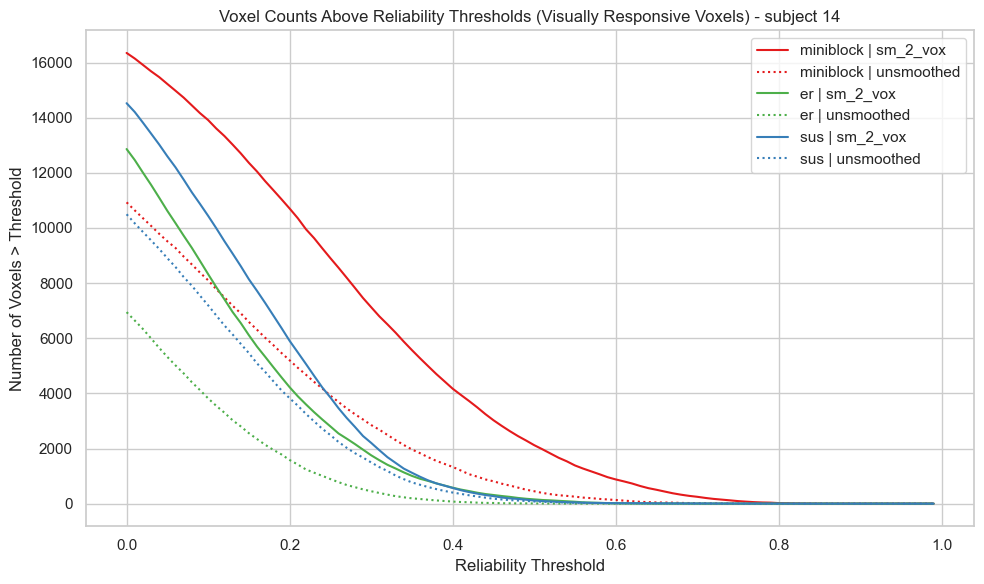

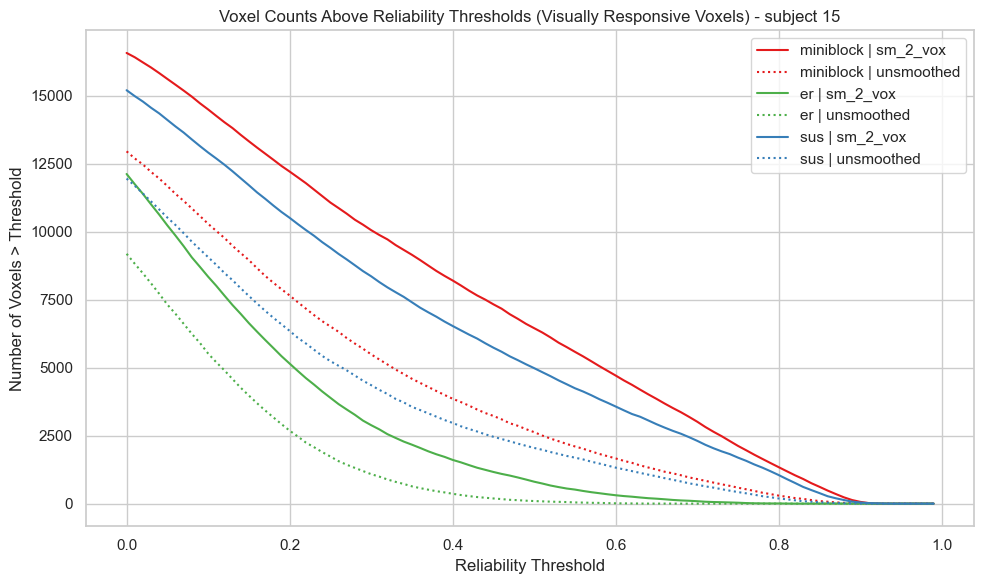

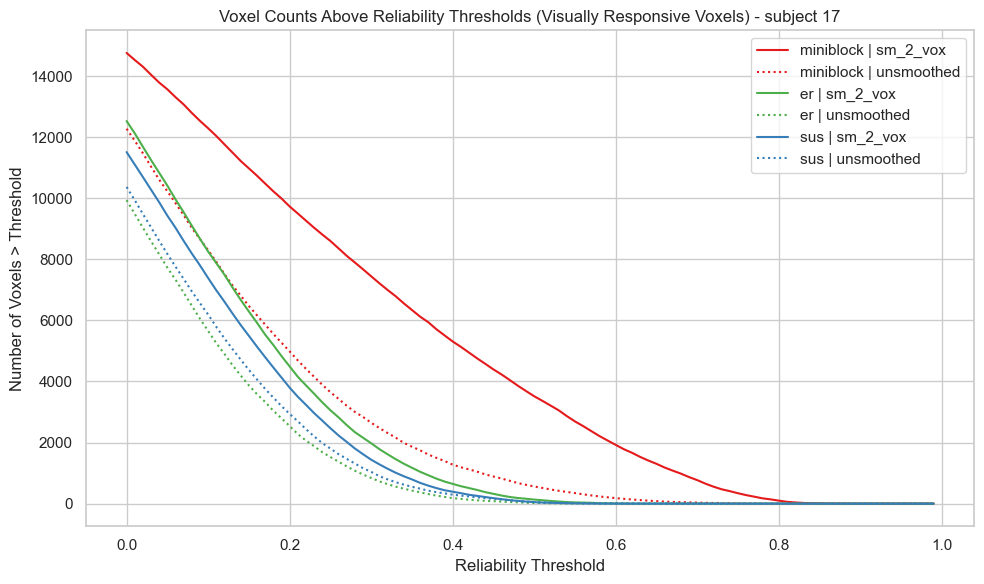

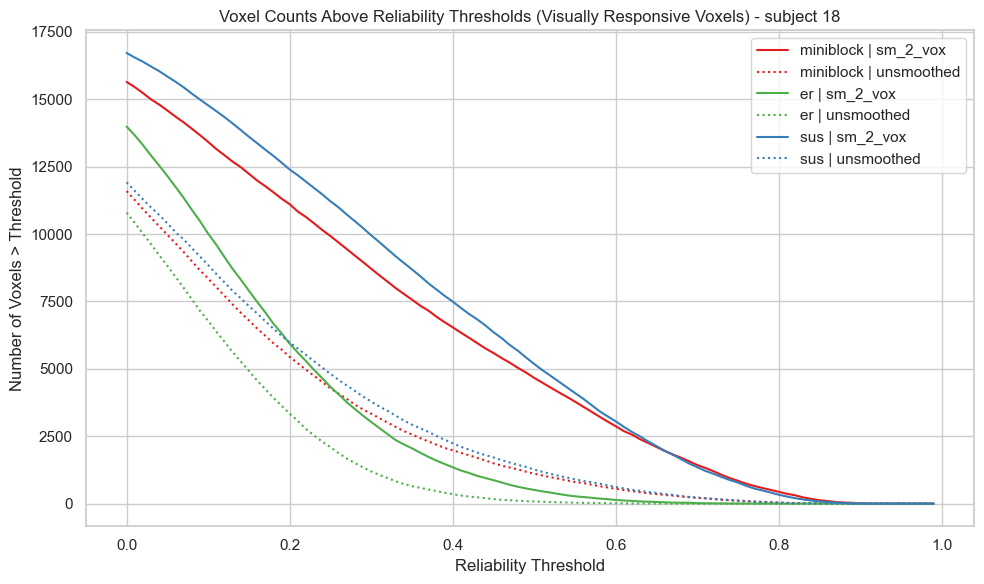

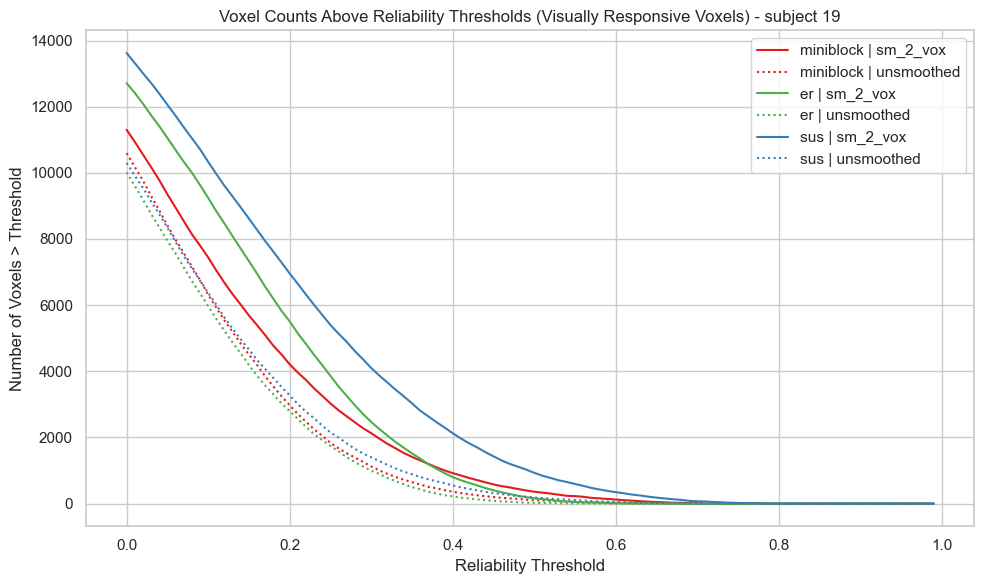

In [26]:
# Define mapping from smoothing type to line style
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("Set1", n_colors=3)
smoothing_to_linestyle = {
    'sm_2_vox': '-', 
    'unsmoothed': ':'
}

# Define mapping from runtype/condition to color
runtype_to_color = {
    'miniblock': colors[0], 
    'sus': colors[1], 
    'er': colors[2]
}

for sub in subs:
    plt.figure(figsize=(10, 6))

    for entry in threshold_counts:
        if entry['subject'] == sub:
            smoothing = entry['smoothing']
            runtype = entry['runtype']
            
            linestyle = smoothing_to_linestyle.get(smoothing, '-')  # fallback to solid line
            color = runtype_to_color.get(runtype, 'black')          # fallback to black

            label = f"{runtype} | {smoothing}"
            plt.plot(thresholds, entry["counts"], label=label, linestyle=linestyle, color=color)

    plt.xlabel("Reliability Threshold")
    plt.ylabel("Number of Voxels > Threshold")
    plt.title(f"Voxel Counts Above Reliability Thresholds (Visually Responsive Voxels) - subject {sub}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
